CNN --> Featrue + Spectrogram

In [9]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
from pathlib import Path
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner.tuners import RandomSearch

# Configuration
SAMPLE_RATE = 22050
DURATION = 5  # seconds
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
MAX_PAD_LEN = int(np.ceil((SAMPLE_RATE * DURATION) / HOP_LENGTH))

# Set base directory: if working inside a notebooks folder, go one level up
BASE_DIR = Path.cwd() if 'notebooks' not in str(Path.cwd()) else Path.cwd().parent

# Define data directories relative to the project root
DATA_DIR = BASE_DIR / 'data'
AUDIO_DIR = DATA_DIR / 'processed' / 'birdcall_segments_5s' / 'birdcall_segments_5s'
FEATURES_CSV = DATA_DIR / 'features' / 'birdcall_features_song.csv'

In [ ]:
# Spetrogram

def load_and_preprocess_audio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)           # Compute Mel spectrogram
        S_dB = librosa.power_to_db(S, ref=np.max)                                                                   # Convert to dB scale                                               
        S_dB = (S_dB - np.min(S_dB)) / (np.max(S_dB) - np.min(S_dB))                                                # Normalization
        S_dB = np.pad(S_dB, ((0, 0), (0, max(0, MAX_PAD_LEN - S_dB.shape[1]))), mode='constant')                    # Pad to fixed length
        S_dB = S_dB[:, :MAX_PAD_LEN]
        return S_dB[..., np.newaxis]                                                                                # Add channel dimension
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [ ]:
# Features and labels

def load_features_and_labels():

    wav_files = list(Path(AUDIO_DIR).glob("*.wav"))                                             # Get all .wav files in the directory
    labels = [f.stem.split('_')[0] for f in wav_files]                                          # Extract labels from filenames
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)                                                     # Encode labels to integers
    
    X_audio = []
    y_clean = []
    file_ids = []
    
    for f, label in zip(wav_files, y):
        spec = load_and_preprocess_audio(f)
        if spec is not None:
            X_audio.append(spec)                                                                # Append the processed spectrogram
            y_clean.append(label)                                                               # Append the corresponding label
            file_ids.append(f.stem)                                                             # Store the filename for matching with CSV features
    
    X_audio = np.array(X_audio)
    y_clean = np.array(y_clean)
    
    try:                                                                                        # Load CSV features
        df_features = pd.read_csv(FEATURES_CSV)
        df_features = df_features[df_features['filename'].str.replace('.wav', '').              # CSV has 'filename' column matching wav filenames
                          isin(file_ids)]
        
        feature_cols = [col for col in df_features.columns if col not in ['file_id', 'label']]  # Exclude non-feature columns
        X_csv = df_features[feature_cols].values                                                # Extract feature values
        X_csv = StandardScaler().fit_transform(X_csv)                                           # Standardize features    
        
        return X_audio, X_csv, y_clean, label_encoder, feature_cols
    
    except Exception as e:
        print(f"Error loading CSV features: {e}")
        return X_audio, None, y_clean, label_encoder, None

In [ ]:
# Model architecture with both spectrogram and feature data

def build_hybrid_model(hp, input_audio_shape, num_classes, num_features=None):
    audio_input = layers.Input(shape=input_audio_shape, name='audio_input')                 # Input for audio spectrogram
    
    x = audio_input
    for i in range(hp.Int('num_conv_blocks', 2, 4)):                                        # Number of convolutional blocks
        filters = hp.Choice(f'filters_{i}', [32, 64, 128])                                  # Number of filters in convolutional layers             
        kernel_size = hp.Choice(f'kernel_size_{i}', [3, 5])                                 # Kernel size for convolutional layers   
        
        x = layers.Conv2D(filters, (kernel_size, kernel_size),                              # Convolutional layer
                         activation='relu', 
                         padding='same')(x)
        x = layers.BatchNormalization()(x)                                                    
        x = layers.Conv2D(filters, (kernel_size, kernel_size),                              # Second convolutional layer
                         activation='relu', 
                         padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)                                                  # Max pooling layer
        x = layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.4))(x)                           # Dropout layer
    
    x = layers.GlobalAveragePooling2D()(x)                                                  # Global average pooling to flatten the output   
    
    if num_features:
        feature_input = layers.Input(shape=(num_features,), name='feature_input')           # Input for additional features
        y = layers.Dense(hp.Int('feature_dense_units', 32, 128),                            # Dense layer for features
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(feature_input)
        y = layers.BatchNormalization()(y)            
        y = layers.Dropout(hp.Float('feature_dropout', 0.1, 0.5))(y)                        # Dropout for features
        
        combined = layers.concatenate([x, y])                                               # Combine spectrogram and feature data
        inputs = [audio_input, feature_input]
    else:
        combined = x
        inputs = audio_input
    
    z = layers.Dense(hp.Int('dense_units', 128, 512),                                       # Dense layer for combined features          
                    activation='relu',
                    kernel_regularizer=regularizers.l2(0.001))(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(hp.Float('final_dropout', 0.3, 0.6))(z)
    
    output = layers.Dense(num_classes, activation='softmax')(z)                             # Output layer for classification         
    
    model = models.Model(inputs=inputs, outputs=output)                                     # Create the model
    
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [ ]:
# Train model and perform hyperparameter tuning

def train_model_with_tuning():

    X_audio, X_csv, y, label_encoder, feature_cols = load_features_and_labels()
    
    if X_csv is not None:
        X_train_audio, X_test_audio, X_train_csv, X_test_csv, y_train, y_test = train_test_split(               # Split data into training and testing sets
            X_audio, X_csv, y, test_size=0.2, stratify=y, random_state=42)
    else:
        X_train_audio, X_test_audio, y_train, y_test = train_test_split(
            X_audio, y, test_size=0.2, stratify=y, random_state=42)
        X_train_csv, X_test_csv = None, None
    
    input_audio_shape = X_train_audio[0].shape                                                                  # Shape of the audio input (spectrogram)                
    num_classes = len(np.unique(y))                                                                             # Number of unique classes in the labels                    
    num_features = len(feature_cols) if feature_cols else None                                                  # Number of additional features if available    
    
    tuner = RandomSearch(                                                                                       # Hyperparameter tuning
        lambda hp: build_hybrid_model(hp, input_audio_shape, num_classes, num_features),
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='tuning',
        project_name='bird_sound_classification')
    
    train_inputs = {'audio_input': X_train_audio}                                                               # Prepare input data for tuning
    val_inputs = {'audio_input': X_test_audio}
    
    if X_csv is not None:
        train_inputs['feature_input'] = X_train_csv
        val_inputs['feature_input'] = X_test_csv
    
    tuner.search(train_inputs, y_train,                                                                         # Tuen the model with training data
                 validation_data=(val_inputs, y_test),
                 epochs=30,
                 batch_size=32,
                 callbacks=[EarlyStopping(patience=3)])
    
    best_model = tuner.get_best_models(num_models=1)[0]                                                         # Get the best model from tuning
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)                      # Train with more epochs on best configuration
    
    history = best_model.fit(train_inputs, y_train,                                                             # Fit the best model on training data              
                            validation_data=(val_inputs, y_test),
                            epochs=100,
                            batch_size=32,
                            callbacks=[EarlyStopping(patience=5), reduce_lr])
    
    return best_model, history, label_encoder, (X_test_audio, X_test_csv), y_test



# Evaluate model performance

def evaluate_model(model, label_encoder, X_test, y_test):
    test_inputs = {'audio_input': X_test[0]}                                                                    # Prepare input data for evaluation                     
    if len(X_test) > 1 and X_test[1] is not None:
        test_inputs['feature_input'] = X_test[1]
    
    test_loss, test_acc = model.evaluate(test_inputs, y_test)                                                   # Evaluate the model on test data         
    print(f"Test Accuracy: {test_acc:.4f}")
    
    y_pred = np.argmax(model.predict(test_inputs), axis=1)                                                      # Predict labels for test data          
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    cm = confusion_matrix(y_test, y_pred)                                                                       # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_, cmap='Blues')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    return test_acc

Error loading CSV features: could not convert string to float: 'greater_rhea'
Reloading Tuner from tuning\bird_sound_classification\tuner0.json
Epoch 1/100
63/63 [==============================] - 316s 5s/step - loss: 2.6875 - accuracy: 0.2975 - val_loss: 4.9178 - val_accuracy: 0.1400 - lr: 0.0100
Epoch 2/100
63/63 [==============================] - 318s 5s/step - loss: 2.5676 - accuracy: 0.3435 - val_loss: 3.7195 - val_accuracy: 0.1660 - lr: 0.0100
Epoch 3/100
63/63 [==============================] - 338s 5s/step - loss: 2.5316 - accuracy: 0.3475 - val_loss: 3.3108 - val_accuracy: 0.2360 - lr: 0.0100
Epoch 4/100
63/63 [==============================] - 336s 5s/step - loss: 2.4049 - accuracy: 0.3800 - val_loss: 3.5999 - val_accuracy: 0.2180 - lr: 0.0100
Epoch 5/100
63/63 [==============================] - 322s 5s/step - loss: 2.2694 - accuracy: 0.4225 - val_loss: 6.3540 - val_accuracy: 0.1500 - lr: 0.0100
Epoch 6/100
63/63 [==============================] - 313s 5s/step - loss: 2.2341 

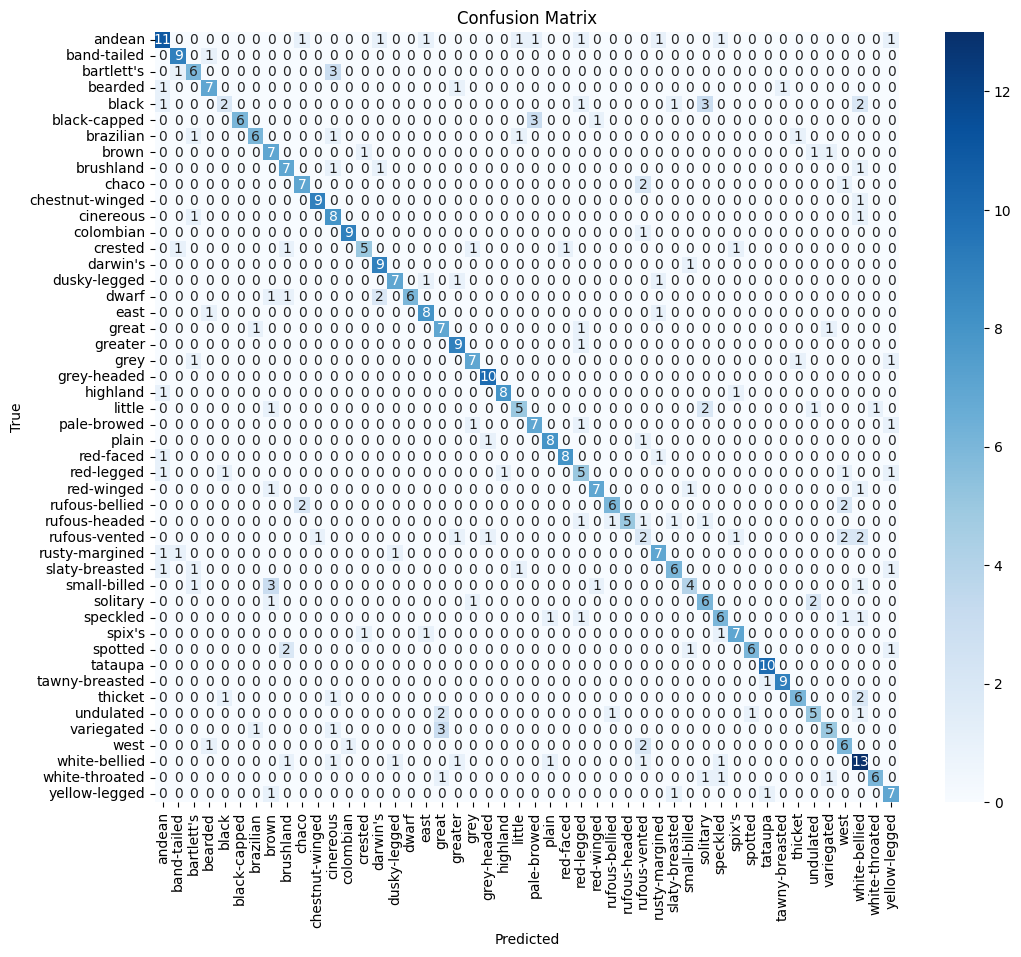

Model saved with test accuracy: 0.6640


In [ ]:
# Main execution

if __name__ == "__main__":
    model, history, label_encoder, X_test, y_test = train_model_with_tuning()
    test_acc = evaluate_model(model, label_encoder, X_test, y_test)
    
    # Save the model
    model.save('bird_sound_classifier.h5')
    print(f"Model saved with test accuracy: {test_acc:.4f}")